In [10]:
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import numpy as np

In [13]:
def process_one_file(filename):
    with open(filename, 'r') as f:
        results = json.load(f)
    patients = [int(x.split('_')[0]) for x in results.keys()]
    sup_results_acc = list()
    sup_results_kappa = list()
    log_results_acc = list()
    log_results_kappa = list()
    fine_results_acc = list()
    fine_results_kappa = list()
    for value in results.values():
        sup_results_acc.append(np.mean([value['sup_res'][i][0]['test_acc'] for i in range(len(value['sup_res']))]))
        sup_results_kappa.append(np.mean([value['sup_res'][i][0]['kappa'] for i in range(len(value['sup_res']))]))
        log_results_acc.append(np.mean([value['logistic_res'][i][0]['test_acc'] for i in range(len(value['logistic_res']))]))
        log_results_kappa.append(np.mean([value['logistic_res'][i][0]['kappa'] for i in range(len(value['logistic_res']))]))
        fine_results_acc.append(np.mean([value['fully_tuned_res'][i][0]['test_acc'] for i in range(len(value['fully_tuned_res']))]))
        fine_results_kappa.append(np.mean([value['fully_tuned_res'][i][0]['kappa'] for i in range(len(value['fully_tuned_res']))]))
    return {
        'patients': patients,
        'sup_results_acc': sup_results_acc,
        'sup_results_kappa': sup_results_kappa,
        'log_results_acc': log_results_acc,
        'log_results_kappa': log_results_kappa,
        'fine_results_acc': fine_results_acc,
        'fine_results_kappa': fine_results_kappa
    }

In [12]:
def plot_simclr(patients, sup_results, log_results, fine_results, ylabel="Test accuracy", save_name=None):
    fig = plt.figure(figsize=(12,8))
    plt.plot(patients, sup_results, '--', color="skyblue", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=14)
    plt.plot(patients, log_results, '--', color="darkred", marker="^", markeredgecolor="#000", markerfacecolor="y", markersize=14)
    plt.plot(patients, fine_results, '--', color="forestgreen", marker="o", markeredgecolor="#000", markerfacecolor="y", markersize=12)
    plt.xscale("log")
    plt.xticks(patients, labels=patients)
    plt.title("SimCLR results, pretrained on 3000 patients")
    plt.xlabel("Number of labelled patients used")
    plt.ylabel(ylabel + " on test set")
    plt.minorticks_off()
    plt.legend(["Fully supervised (no pretraining)", "Frozen pretrained backbone", "Fine-tuned backbone"])
    if save_name is not None:
        plt.savefig(save_name, facecolor="white")
    plt.show()

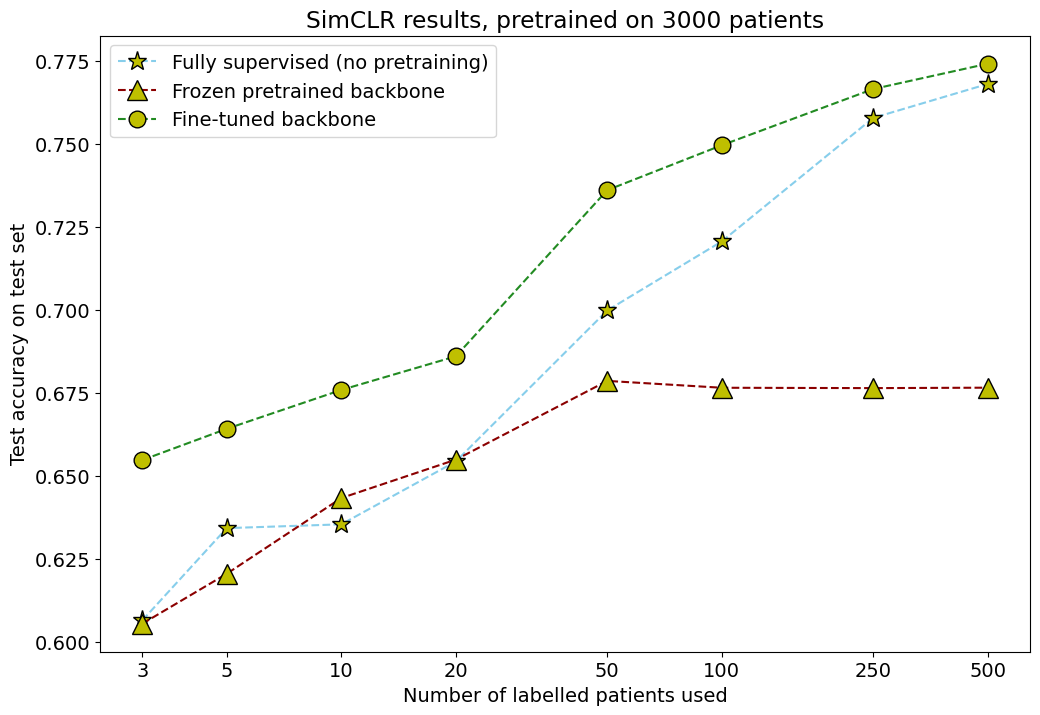

In [15]:
sample_results = process_one_file('sample_results')
plot_simclr(sample_results['patients'], sample_results['sup_results_acc'], sample_results['log_results_acc'], sample_results['fine_results_acc'])

In [23]:
def process_multiple_files(filenames):
    """
        To process multiple files, they must contain the same data structure
    """
    patients = process_one_file(filenames[0])['patients']
    n_patients = len(patients)
    n_files = len(filenames)
    n_metrics = 6
    all_results = np.ndarray((n_files, n_metrics, n_patients))
    for i, filename in enumerate(filenames):
        file_results = process_one_file(filename)
        all_results[i, :, :] = list(file_results.values())[1:]
    mean_results = np.mean(all_results, axis=0)
    std_results = np.std(all_results, axis=0)
    return {
        'patients': patients,
        'sup_results_acc': {'mean': mean_results[0,:], 'std': std_results[0,:]},
        'sup_results_kappa': {'mean': mean_results[1,:], 'std': std_results[1,:]},
        'log_results_acc': {'mean': mean_results[2,:], 'std': std_results[2,:]},
        'log_results_kappa': {'mean': mean_results[3,:], 'std': std_results[3,:]},
        'fine_results_acc': {'mean': mean_results[4,:], 'std': std_results[4,:]},
        'fine_results_kappa': {'mean': mean_results[5,:], 'std': std_results[5,:]},
    }

In [27]:
all_results = process_multiple_files(['sample_results', 'sample_results2'])
all_results['sup_results_acc']['mean']

array([0.60676983, 0.63528772, 0.63465707, 0.65803329, 0.70551737,
       0.72399835, 0.75686345, 0.76828226])

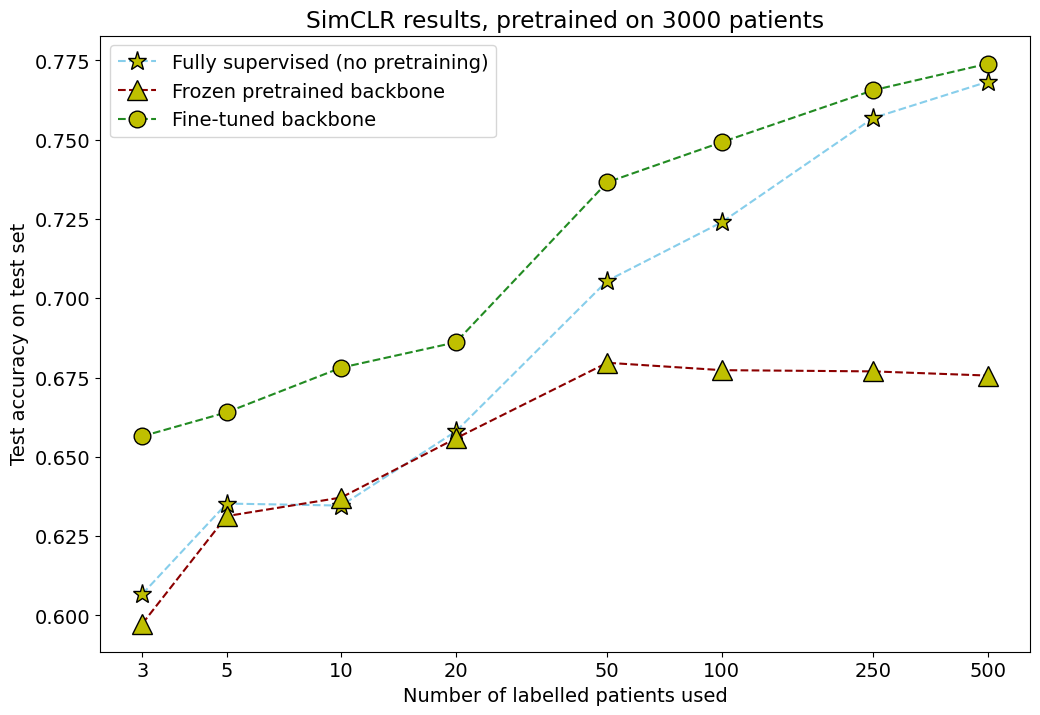

In [28]:
plot_simclr(all_results['patients'], all_results['sup_results_acc']['mean'], all_results['log_results_acc']['mean'], all_results['fine_results_acc']['mean'])